# QC Benchmark (Resource-Matched)

実験用ノートブック。`quant_benchmark_suite.py` をインポートして実行・可視化します。

In [4]:

%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.path.dirname(r"quant_benchmark_suite_alt.py"))
sys.path.append("/mnt/data")

from quant_benchmark_suite_alt import run_benchmark, plot_overlay, plot_parity, plot_rolling_rmse


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) パラメータ

In [12]:

CSV_PATH = None  # データがこのノートと同じ場所にあるなら None
WINDOW   = 5
TRAIN    = 0.8
VAL      = 0.0
KX_MAP   = {3:6, 6:6}   # 入力PCA次元
KY       = 3           # 出力PCA次元
MAXITER  = 250
BATCH    = 32
QRC_LAGS = 3
TARGET   = "price"     # または 'Ret'


## 2) 実行

In [13]:

metrics, preds, d_te, Y_te, series_names = run_benchmark(
    csv_path=CSV_PATH, window=WINDOW, target=TARGET,
    train_ratio=TRAIN, val_ratio=VAL,
    kx_map=KX_MAP, ky=KY, maxiter=MAXITER, batch=BATCH, qrc_lags=QRC_LAGS
)
metrics


[RUN] Amplitude+VQA (3q)
[RUN] Angle+VQA (LinearCX, 3q)
[RUN] Angle+VQA (LinearCX, 6q)
[RUN] Angle+VQA (Chain-RyRz, 3q)
[RUN] Angle+VQA (Chain-RyRz, 6q)
[RUN] Angle+VQA (Efficient-SU2, 3q)
[RUN] Angle+VQA (Efficient-SU2, 6q)
[RUN] QRC (QR2, 3q)
[RUN] QRC (QR2, 6q)


,Model,MSE,RMSE,MAE,Bias,Corr,R2,QLIKE
0,"Angle+VQA (Chain-RyRz, 3q)",0.000111,0.010518,0.007850,0.000470,0.994013,0.987860,0.002256
1,"Angle+VQA (Efficient-SU2, 3q)",0.000113,0.010629,0.008022,-0.000768,0.993815,0.987601,0.001878
2,"Angle+VQA (LinearCX, 6q)",0.000114,0.010684,0.007925,0.000377,0.993831,0.987473,0.002318
3,"Angle+VQA (LinearCX, 3q)",0.000115,0.010701,0.007938,0.000354,0.993809,0.987434,0.002326
4,"Angle+VQA (Chain-RyRz, 6q)",0.000117,0.010799,0.008046,-0.000534,0.993654,0.987202,0.002291
5,"Angle+VQA (Efficient-SU2, 6q)",0.000121,0.011020,0.008289,-0.001126,0.993434,0.986675,0.001804
6,"QRC (QR2, 3q)",0.000240,0.015481,0.010131,-0.007110,0.989632,0.973701,0.004123
7,Amplitude+VQA (3q),0.000288,0.016962,0.013369,-0.012535,0.993733,0.968426,0.004635
8,"QRC (QR2, 6q)",0.000465,0.021553,0.015602,-0.011589,0.982331,0.949022,0.006429


## 3) 可視化

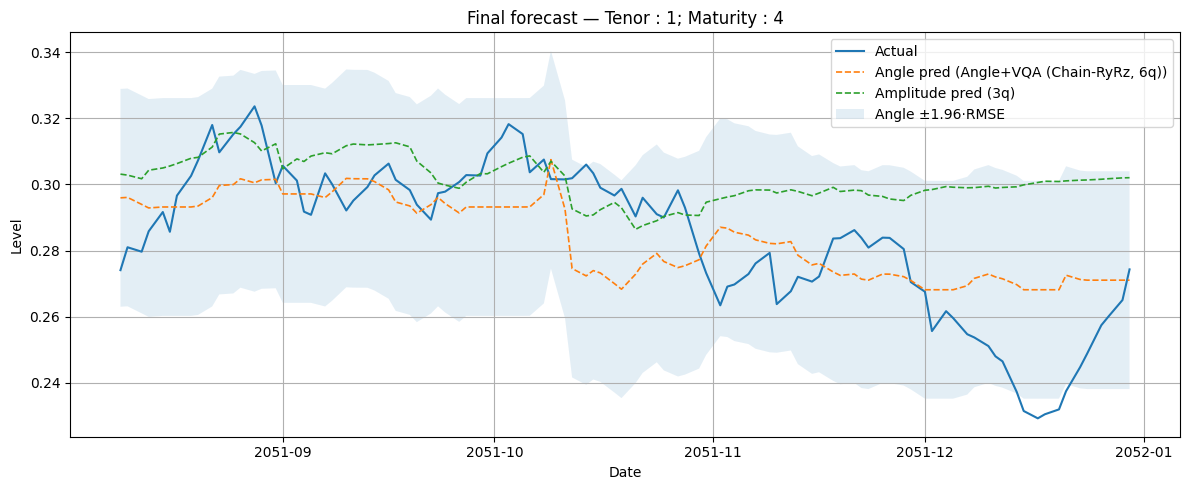

In [17]:
# --- Final forecast plot (Unified-style) : Angle vs Amplitude with 95% RMSE band ---

import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1) どの Angle / Amplitude を使うか（名前は quant_benchmark_suite.py の既定）
ANGLE_KEYS = [
    "Angle+VQA (Chain-RyRz, 6q)",
    "Angle+VQA (Chain-RyRz, 3q)",
    "Angle+VQA (LinearCX, 6q)",
    "Angle+VQA (LinearCX, 3q)",
    "Angle+VQA (Efficient-SU2, 6q)",
    "Angle+VQA (Efficient-SU2, 3q)",
]
AMP_KEY   = "Amplitude+VQA (3q)"

# 使えるAngleモデルのうち、最初に見つかったものを採用
angle_key = next((k for k in ANGLE_KEYS if k in preds), None)
if angle_key is None:
    raise ValueError("Angle系の予測が見つかりません。preds のキーを print して確認してください。")

if AMP_KEY not in preds:
    raise ValueError("Amplitude系の予測が見つかりません。preds のキーを print して確認してください。")

pred_angle = preds[angle_key]
pred_amp   = preds[AMP_KEY]
Y_true     = Y_te
dates      = np.array(d_te)  # matplotlib で扱いやすいように配列化

# 2) 対象系列（fi）を選ぶ：中央の系列を既定に
M = Y_true.shape[1]
fi = M // 2  # 任意に変えてOK（series_namesをprintして名前で選んでも良い）

# 3) 長さがズレる場合の合わせこみ
n = min(len(Y_true), len(pred_angle), len(pred_amp))
y_true_1d   = Y_true[-n:, fi]
y_angle_1d  = pred_angle[-n:, fi]
y_amp_1d    = pred_amp[-n:, fi]
dates_1d    = dates[-n:]

# 4) RMSE（Angle基準）を計算し、±1.96*RMSE の帯を作成
rmse = math.sqrt(mean_squared_error(y_true_1d, y_angle_1d))
upper = y_angle_1d + 1.96 * rmse
lower = y_angle_1d - 1.96 * rmse

# 5) 描画（Unified風）
plt.figure(figsize=(12,5))
plt.plot(dates_1d, y_true_1d,  label='Actual', linewidth=1.5)
plt.plot(dates_1d, y_angle_1d, '--', label=f'Angle pred ({angle_key})', linewidth=1.2)
plt.plot(dates_1d, y_amp_1d,   '--', label='Amplitude pred (3q)', linewidth=1.2)
plt.fill_between(dates_1d, lower, upper, alpha=0.12, label='Angle ±1.96·RMSE')
ttl = f'Final forecast — {series_names[fi] if isinstance(series_names, list) else f"series[{fi}]"}'
plt.title(ttl)
plt.xlabel('Date'); plt.ylabel('Level')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

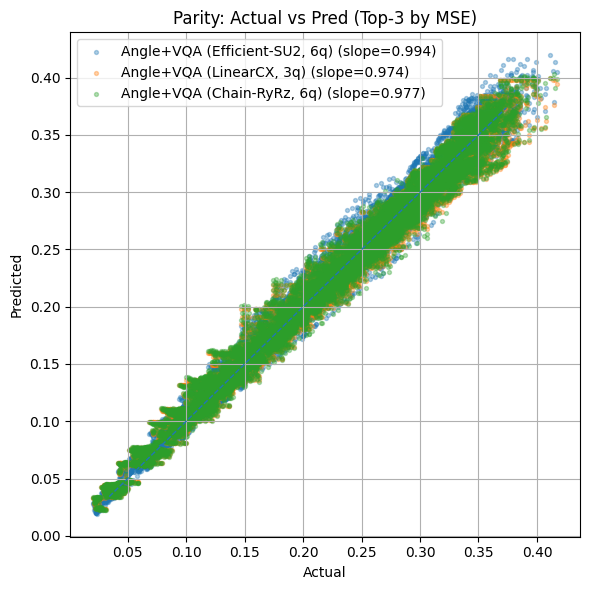

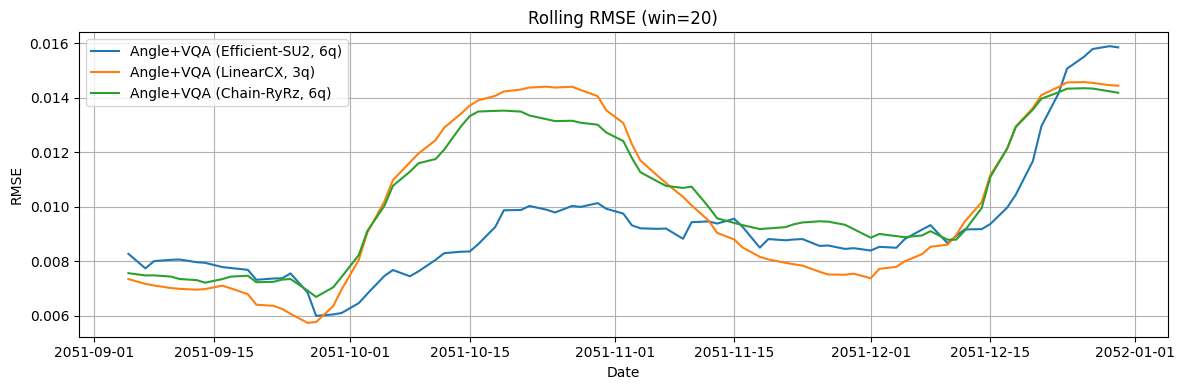

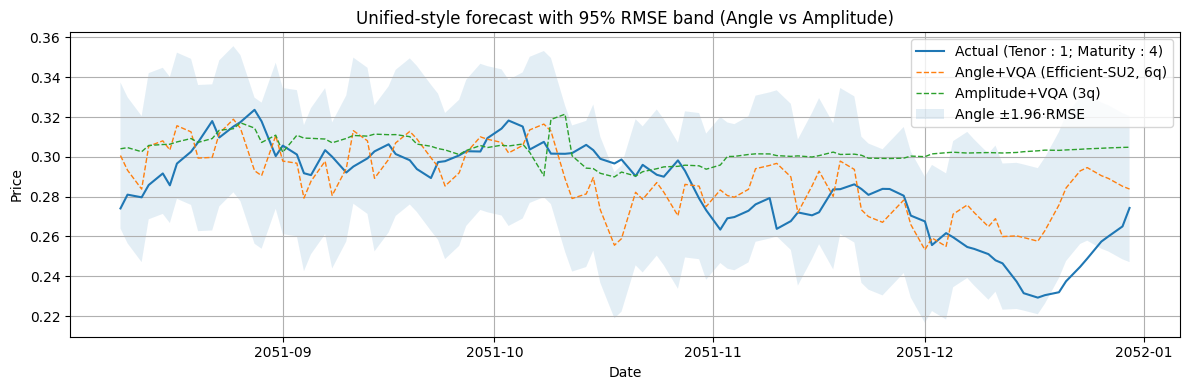

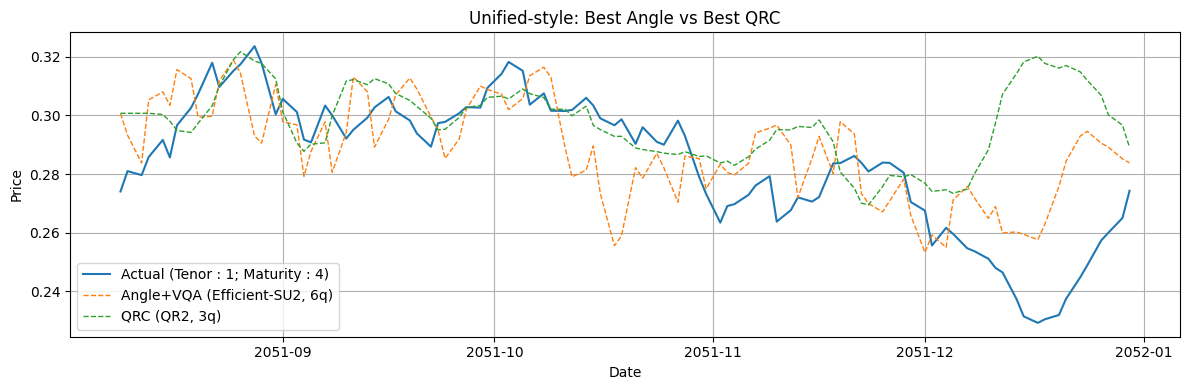

In [11]:
# === One-shot comparison plots (for run_benchmark outputs) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def _align_true_pred(Y_true, Y_pred):
    n = min(Y_true.shape[0], Y_pred.shape[0])
    return Y_true[-n:, :], Y_pred[-n:, :]

# ---- 1) Parity: Actual vs Pred (Top-3 models)
def plot_top3_parity(metrics, preds, Y_te, title_suffix="(Top-3 by MSE)"):
    top3 = metrics.sort_values("MSE").head(3)["Model"].tolist()
    plt.figure(figsize=(6,6))
    y_all = None
    for name in top3:
        Yt, Yp = _align_true_pred(Y_te, preds[name])
        y = Yt.flatten()
        p = Yp.flatten()
        if y_all is None:
            y_all = y
        m, b = np.polyfit(y, p, 1)
        plt.scatter(y, p, s=8, alpha=0.35, label=f"{name} (slope={m:.3f})")
    lo, hi = np.nanpercentile(np.concatenate([y_all, preds[top3[0]].flatten()]), [1, 99])
    plt.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)
    plt.title(f"Parity: Actual vs Pred {title_suffix}")
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.show()

# ---- 2) Rolling RMSE
def plot_rolling_rmse(preds, Y_te, d_te, model_names=None, window=20):
    names = model_names or list(preds.keys())
    plt.figure(figsize=(12,4))
    for name in names:
        Yt, Yp = _align_true_pred(Y_te, preds[name])
        se = ((Yt - Yp)**2).mean(axis=1)
        rm = pd.Series(se, index=pd.to_datetime(d_te[-len(se):])).rolling(window).mean()**0.5
        plt.plot(rm.index, rm.values, label=f"{name}")
    plt.title(f"Rolling RMSE (win={window})")
    plt.xlabel("Date"); plt.ylabel("RMSE")
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.show()

# ---- 3) Unified-style 95% RMSE band (Angle vs Amplitude vs QRC)
def plot_unified_band(Y_te, preds, d_te, series_names,
                      angle_key="Angle+VQA (Efficient-SU2, 6q)",
                      amp_key="Amplitude+VQA (3q)",
                      qrc_key="QRC (QR2, 3q)",
                      series_index=None):
    fi = series_index if series_index is not None else (Y_te.shape[1] // 2)

    if angle_key not in preds or amp_key not in preds:
        print("[warn] 指定モデルが preds に見つかりません。keys=", list(preds.keys())[:5], "...")
        return

    Yt_a, Pa = _align_true_pred(Y_te, preds[angle_key])
    Yt_b, Pb = _align_true_pred(Y_te, preds[amp_key])
    n = min(Yt_a.shape[0], Yt_b.shape[0])
    Yt, Pa, Pb = Yt_a[-n:, fi], Pa[-n:, fi], Pb[-n:, fi]
    dates = pd.to_datetime(d_te[-n:])
    rmse = np.sqrt(mean_squared_error(Yt, Pa))

    plt.figure(figsize=(12,4))
    plt.plot(dates, Yt, label=f"Actual ({series_names[fi] if series_names else 'series'})", linewidth=1.5)
    plt.plot(dates, Pa, '--', label=f"{angle_key}", linewidth=1)
    plt.plot(dates, Pb, '--', label=f"{amp_key}", linewidth=1)
    plt.fill_between(dates, Pa - 1.96*rmse, Pa + 1.96*rmse, alpha=0.12, label="Angle ±1.96·RMSE")
    plt.title("Unified-style forecast with 95% RMSE band (Angle vs Amplitude)")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    if qrc_key in preds:
        Yt_c, Pc = _align_true_pred(Y_te, preds[qrc_key])
        m = min(Yt_a.shape[0], Yt_c.shape[0])
        Yt2, Pa2, Pc2 = Yt_a[-m:, fi], Pa[-m:], Pc[-m:, fi]
        dates2 = pd.to_datetime(d_te[-m:])
        plt.figure(figsize=(12,4))
        plt.plot(dates2, Yt2, label=f"Actual ({series_names[fi] if series_names else 'series'})", linewidth=1.5)
        plt.plot(dates2, Pa2, '--', label=f"{angle_key}", linewidth=1)
        plt.plot(dates2, Pc2, '--', label=f"{qrc_key}", linewidth=1)
        plt.title("Unified-style: Best Angle vs Best QRC")
        plt.xlabel("Date"); plt.ylabel("Price")
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# === 実行 ===
plot_top3_parity(metrics, preds, Y_te, title_suffix="(Top-3 by MSE)")

top3_names = metrics.sort_values("MSE").head(3)["Model"].tolist()
plot_rolling_rmse(preds, Y_te, d_te, model_names=top3_names, window=20)

angle_best = metrics.sort_values("MSE").query("Model.str.contains('Angle')", engine="python").iloc[0]["Model"]
amp_key = next((k for k in preds.keys() if "Amplitude+VQA" in k), None)
qrc_key = next((k for k in preds.keys() if k.startswith("QRC")), None)

plot_unified_band(Y_te, preds, d_te, series_names,
                  angle_key=angle_best,
                  amp_key=amp_key if amp_key else list(preds.keys())[0],
                  qrc_key=qrc_key if qrc_key else None)